### 1. Laboratorio clase 7: Introducción y contexto


En este laboratorio exploraremos la técnica de ajuste de parámetros conocida como **LoRA (Low-Rank Adaptation)**, que permite adaptar modelos grandes sin necesidad de actualizar todos sus parámetros. La idea central de LoRA es congelar los pesos originales del modelo y entrenar únicamente un conjunto de capas adicionales que modifican el comportamiento del modelo de manera eficiente y controlada.

Este laboratorio tiene los siguientes objetivos:

- Comprender los fundamentos matemáticos y computacionales de LoRA.
- Implementar manualmente una versión simplificada de LoRA sobre una capa lineal congelada.
- Visualizar la pérdida de entrenamiento y las matrices de pesos para entender el efecto de la adaptación.
- Aplicar LoRA en un modelo preentrenado real (`flan-t5-small`) para una tarea de resumen automático.
- Comparar el rendimiento de LoRA contra el ajuste completo del modelo en términos de calidad del resumen generado.

### 2. LoRA desde hecha en casa

En esta sección construiremos una versión simplificada de LoRA desde cero, utilizando PyTorch. Simularemos un escenario en el que tenemos una **capa lineal preentrenada** cuyos pesos están congelados (es decir, no se pueden modificar).

Para adaptar esta capa a un nuevo conjunto de datos, introduciremos un módulo adicional que aprende una **matriz de actualización de bajo rango** usando dos capas lineales (A y B). Este módulo se entrena mientras la capa original permanece intacta.

Esta implementación nos permitirá entender:
- Cómo se construye la arquitectura de LoRA manualmente.
- Cómo se entrena solo la parte adaptable del modelo.
- Qué papel juegan los hiperparámetros `r` (rango) y `alpha` (escalamiento).

In [1]:
# Importamos librerías necesarias

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

In [2]:
# Simulamos datos de entrenamiento y definimos clases para llevar a cabo el fine-tuning

x = torch.randn(64, 64) 
target = torch.randn(64, 32) 

class FrozenLinear(nn.Module):
    """
    Capa lineal con pesos y bias congelados (no entrenables).

    Args:
        in_features (int): Número de características de entrada.
        out_features (int): Número de características de salida.
    """
    def __init__(self, in_features, out_features):
        """
        Inicializa la capa FrozenLinear con pesos aleatorios y bias en cero.

        Args:
            in_features (int): Número de características de entrada.
            out_features (int): Número de características de salida.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.weight.requires_grad = False
        self.bias.requires_grad = False

    def forward(self, x):
        """
        Realiza la pasada hacia adelante usando los pesos y bias congelados.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Salida de la capa lineal.
        """
        return F.linear(x, self.weight, self.bias)

class LoRALinear(nn.Module):
    """
    Capa lineal con adaptación LoRA sobre una capa congelada.

    Args:
        frozen_layer (FrozenLinear): Capa lineal congelada.
        r (int): Rango de la descomposición de LoRA.
        alpha (int): Escalado de LoRA.
    """
    def __init__(self, frozen_layer, r=4, alpha=8):
        """
        Inicializa la capa LoRALinear con matrices A y B entrenables.

        Args:
            frozen_layer (FrozenLinear): Capa lineal congelada.
            r (int): Rango de la descomposición de LoRA.
            alpha (int): Escalado de LoRA.
        """
        super().__init__()
        self.frozen = frozen_layer
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r
        in_features = frozen_layer.weight.shape[1]
        out_features = frozen_layer.weight.shape[0]

        self.A = nn.Linear(in_features, r, bias=False)
        self.B = nn.Linear(r, out_features, bias=False)

        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        """
        Realiza la pasada hacia adelante sumando la salida congelada y la adaptación LoRA.

        Args:
            x (torch.Tensor): Tensor de entrada.

        Returns:
            torch.Tensor: Salida de la capa LoRA.
        """
        return self.frozen(x) + self.scaling * self.B(self.A(x))

In [3]:
# Definimos capas congeladas y LoRA, optimizador y hacemos fine-tuning

frozen_layer = FrozenLinear(64, 32)
lora_layer = LoRALinear(frozen_layer)
optimizer = torch.optim.Adam(lora_layer.parameters(), lr=1e-2)

losses = []
for epoch in range(100):
    optimizer.zero_grad()
    output = lora_layer(x)
    loss = F.mse_loss(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

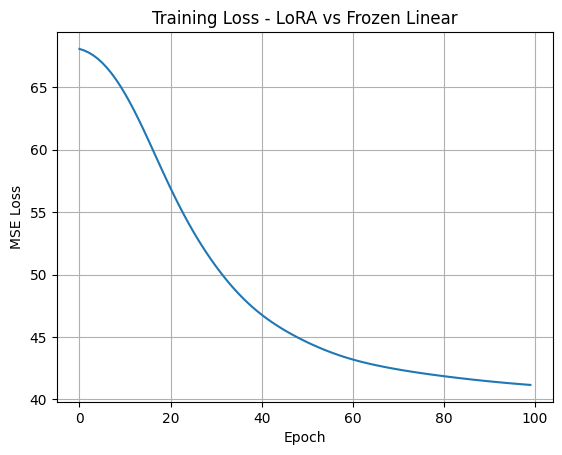

In [4]:
# Visualizamos la pérdida durante el fine-tuning

plt.plot(losses)
plt.title("Training Loss - LoRA vs Frozen Linear")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

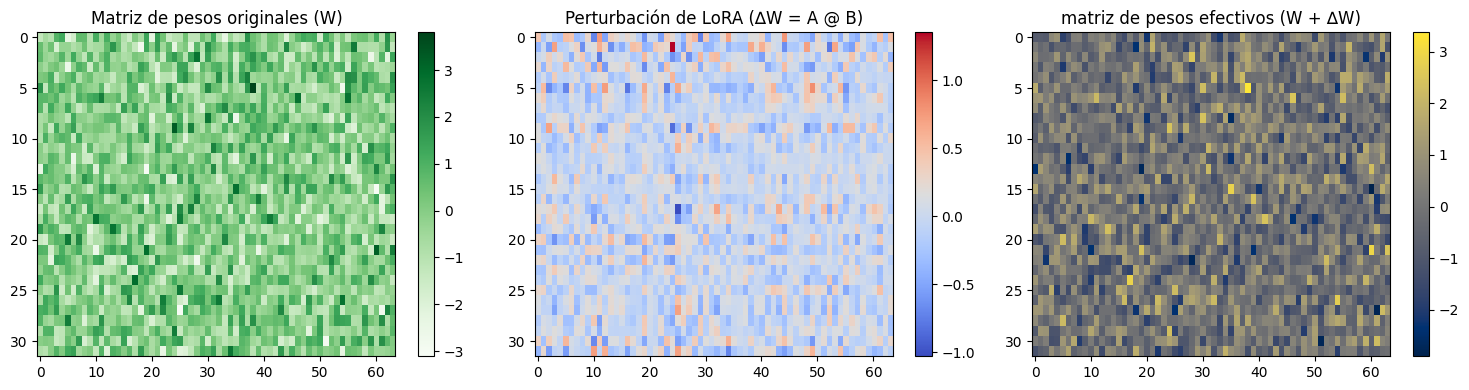

In [5]:
# Visualización de pesos antes y después del fine-tuning

with torch.no_grad():
    A = lora_layer.A.weight  
    B = lora_layer.B.weight  
    delta_W = (A.T @ B.T).T  

    W_frozen = frozen_layer.weight.detach()
    W_effective = W_frozen + delta_W

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(W_frozen.numpy(), aspect='auto', cmap='Greens')
plt.title("Matriz de pesos originales (W)")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(delta_W.numpy(), aspect='auto', cmap='coolwarm')
plt.title("Perturbación de LoRA (∆W = A @ B)")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(W_effective.numpy(), aspect='auto', cmap='cividis')
plt.title("matriz de pesos efectivos (W + ∆W)")
plt.colorbar()

plt.tight_layout()
plt.show()



### 3. Generación de resúmenes: Modelo pre-entrenado vs modelos con fine-tuning

Ahora vamos a algo más realista. Vamos a utilizar un modelo preentrenado: **`google/flan-t5-small`**, diseñado para tareas de generación de texto.

En esta sección:
- Cargaremos y preprocesaremos el conjunto de datos `XSum` para tareas de resumen automático.
- Evaluaremos la capacidad del modelo original (zero-shot).
- Aplicaremos **LoRA** sobre el modelo T5 utilizando la librería `peft` de Hugging Face.
- Entrenaremos solo los adaptadores LoRA, manteniendo el resto del modelo congelado.

Esta parte es esencial para ver cómo se aplica LoRA en la práctica con un modelo grande y un conjunto de datos real. Además, compararemos el rendimiento del modelo pre-entrenado con diferentes fine-tunings.

In [6]:
# Importamos librerías necesarias

from datasets import load_dataset
from transformers import AutoTokenizer, T5ForConditionalGeneration
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType
import pandas as pd

W0521 12:21:29.986000 10601 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [7]:
# Importamos modelo pre-entrenado, tokenizador, dataset y procesamos los datos

model_id = "google/flan-t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_full = T5ForConditionalGeneration.from_pretrained(model_id)
model_full = model_full.to("cpu")

dataset = load_dataset("xsum")
dataset = dataset["train"].select(range(300)).train_test_split(test_size=0.1)

max_input_length = 128
max_target_length = 32

def preprocess(example):
    """
    Preprocesa un ejemplo del dataset para el modelo T5, agregando el prompt y tokenizando.

    Args:
        example (dict): Diccionario con las claves 'document' y 'summary'.

    Returns:
        dict: Diccionario con los input_ids y labels tokenizados.
    """
    inputs = ["summarize: " + doc for doc in example["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(example["summary"], max_length=max_target_length, padding="max_length", truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess, batched=True, remove_columns=dataset["train"].column_names)

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/fdiazja/nlp_env/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for xsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/xsum
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/270 [00:00<?, ? examples/s]

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3892: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/30 [00:00<?, ? examples/s]

In [8]:
# Generamos texto completo y lo tokenizamos

sample = dataset["test"][0]["document"]
ref_summary = dataset["test"][0]["summary"]
input_ids = tokenizer("summarize: " + sample, return_tensors="pt", truncation=True, max_length=512).input_ids.to("cpu")
output_full = model_full.generate(input_ids, max_length=128)
summary_full = tokenizer.decode(output_full[0], skip_special_tokens=True)

print("\nTexto original:\n", sample[:565])


Texto original:
 The animal has been studied for some time, but new research confirms it is different from all other gibbons.
It has been named the Skywalker hoolock gibbon - partly because the Chinese characters of its scientific name mean "Heaven's movement" but also because the scientists are fans of Star Wars.
The study is published in the American Journal of Primatology.
Dr Sam Turvey, from the Zoological Society of London, who was part of the team studying the apes, told BBC News: "In this area, so many species have declined or gone extinct because of habitat loss, hunt


In [9]:
# Generamos resumen usando el modelo original
model_zero = T5ForConditionalGeneration.from_pretrained(model_id).to("cpu")
input_ids_zero = tokenizer("summarize: " + sample, return_tensors="pt").input_ids.to("cpu")
output_zero = model_zero.generate(input_ids_zero, max_length=64)
summary_zero = tokenizer.decode(output_zero[0], skip_special_tokens=True)

print("\nResumen generado (Zero-shot, modelo preentrenado sin fine-tuning):\n", summary_zero)

Token indices sequence length is longer than the specified maximum sequence length for this model (716 > 512). Running this sequence through the model will result in indexing errors



Resumen generado (Zero-shot, modelo preentrenado sin fine-tuning):
 A new species of ape has been named Skywalker hoolock gibbons, a study suggests.


In [10]:
# Realizamos fine-tuning cmpleto del modelo pre-entrenado con el fin de mejorar la generación de resúmenes

args_full = Seq2SeqTrainingArguments(
    output_dir="./flan_full",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none",
    logging_dir=None
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_full)

trainer_full = Seq2SeqTrainer(
    model=model_full,
    args=args_full,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer_full.train()

  0%|          | 0/405 [00:00<?, ?it/s]

/Users/fdiazja/nlp_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'loss': 7.7728, 'grad_norm': 5.838894367218018, 'learning_rate': 4.876543209876544e-05, 'epoch': 0.07}
{'loss': 6.9169, 'grad_norm': 24.41482925415039, 'learning_rate': 4.7530864197530866e-05, 'epoch': 0.15}
{'loss': 9.6999, 'grad_norm': 6.245743751525879, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.22}
{'loss': 7.1617, 'grad_norm': 54.5421142578125, 'learning_rate': 4.506172839506173e-05, 'epoch': 0.3}
{'loss': 5.8134, 'grad_norm': 5.922850608825684, 'learning_rate': 4.3827160493827164e-05, 'epoch': 0.37}
{'loss': 8.4321, 'grad_norm': 227.9540557861328, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.44}
{'loss': 6.2146, 'grad_norm': 20.05206298828125, 'learning_rate': 4.135802469135803e-05, 'epoch': 0.52}
{'loss': 6.6932, 'grad_norm': 6.983939170837402, 'learning_rate': 4.012345679012346e-05, 'epoch': 0.59}
{'loss': 5.6884, 'grad_norm': 16.312223434448242, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}
{'loss': 5.3259, 'grad_norm': 28.635366439819336, 'learning_rate

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 3.878715991973877, 'eval_runtime': 0.4449, 'eval_samples_per_second': 67.433, 'eval_steps_per_second': 33.716, 'epoch': 1.0}
{'loss': 4.2223, 'grad_norm': 7.706539630889893, 'learning_rate': 3.271604938271605e-05, 'epoch': 1.04}
{'loss': 4.3662, 'grad_norm': 15.932634353637695, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}
{'loss': 3.9515, 'grad_norm': 7.621794700622559, 'learning_rate': 3.0246913580246916e-05, 'epoch': 1.19}
{'loss': 3.8027, 'grad_norm': 7.896922588348389, 'learning_rate': 2.9012345679012347e-05, 'epoch': 1.26}
{'loss': 4.0441, 'grad_norm': 33.03179931640625, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}
{'loss': 4.2278, 'grad_norm': 7.891908168792725, 'learning_rate': 2.654320987654321e-05, 'epoch': 1.41}
{'loss': 3.921, 'grad_norm': 15.793388366699219, 'learning_rate': 2.5308641975308646e-05, 'epoch': 1.48}
{'loss': 3.7938, 'grad_norm': 12.3074951171875, 'learning_rate': 2.4074074074074074e-05, 'epoch': 1.56}
{'loss': 4.2509, 'grad_no

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 3.080487012863159, 'eval_runtime': 0.5459, 'eval_samples_per_second': 54.954, 'eval_steps_per_second': 27.477, 'epoch': 2.0}
{'loss': 3.2622, 'grad_norm': 8.70898723602295, 'learning_rate': 1.54320987654321e-05, 'epoch': 2.07}
{'loss': 3.3266, 'grad_norm': 8.875570297241211, 'learning_rate': 1.419753086419753e-05, 'epoch': 2.15}
{'loss': 3.7717, 'grad_norm': 9.595818519592285, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}
{'loss': 3.3553, 'grad_norm': 6.522368907928467, 'learning_rate': 1.1728395061728396e-05, 'epoch': 2.3}
{'loss': 3.2761, 'grad_norm': 6.93324089050293, 'learning_rate': 1.0493827160493827e-05, 'epoch': 2.37}
{'loss': 3.5936, 'grad_norm': 10.164299011230469, 'learning_rate': 9.259259259259259e-06, 'epoch': 2.44}
{'loss': 3.0872, 'grad_norm': 5.592520236968994, 'learning_rate': 8.02469135802469e-06, 'epoch': 2.52}
{'loss': 3.5074, 'grad_norm': 15.959697723388672, 'learning_rate': 6.790123456790123e-06, 'epoch': 2.59}
{'loss': 3.2287, 'grad_norm':

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 2.9037437438964844, 'eval_runtime': 0.3805, 'eval_samples_per_second': 78.839, 'eval_steps_per_second': 39.419, 'epoch': 3.0}
{'train_runtime': 56.5891, 'train_samples_per_second': 14.314, 'train_steps_per_second': 7.157, 'train_loss': 4.552880049340519, 'epoch': 3.0}


TrainOutput(global_step=405, training_loss=4.552880049340519, metrics={'train_runtime': 56.5891, 'train_samples_per_second': 14.314, 'train_steps_per_second': 7.157, 'train_loss': 4.552880049340519, 'epoch': 3.0})

In [11]:
# Generamos un resumen con el modelo completamente ajustado

model_full = model_full.to("cpu")
output_full = model_full.generate(input_ids, max_length=64)
summary_full = tokenizer.decode(output_full[0], skip_special_tokens=True)

print("\nTexto original:\n", sample[:500])
print("\nResumen generado (Fine-tuning completo):\n", summary_full)


Texto original:
 The animal has been studied for some time, but new research confirms it is different from all other gibbons.
It has been named the Skywalker hoolock gibbon - partly because the Chinese characters of its scientific name mean "Heaven's movement" but also because the scientists are fans of Star Wars.
The study is published in the American Journal of Primatology.
Dr Sam Turvey, from the Zoological Society of London, who was part of the team studying the apes, told BBC News: "In this area, so many sp

Resumen generado (Fine-tuning completo):
 A bird has been named the Skywalker hoolock gibbon, a species of which has been spotted in China's Yunnan province.


In [12]:
# Realizamos el fine-tuning del modelo pre-entrenado usando LoRA

base_model = T5ForConditionalGeneration.from_pretrained(model_id).to("cpu")
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)

model_lora = get_peft_model(base_model, lora_config)
model_lora.print_trainable_parameters()

args_lora = Seq2SeqTrainingArguments(
    logging_dir=None,        
    output_dir="./flan_lora",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="no",
    report_to="none",
)

trainer_lora = Seq2SeqTrainer(
    model=model_lora,
    args=args_lora,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

trainer_lora.train()

model_lora = model_lora.to("cpu")
model_lora.base_model = model_lora.base_model.to("cpu") 

trainable params: 344,064 || all params: 77,305,216 || trainable%: 0.445072166928555


  0%|          | 0/405 [00:00<?, ?it/s]

{'loss': 8.0562, 'grad_norm': 0.39174985885620117, 'learning_rate': 4.876543209876544e-05, 'epoch': 0.07}
{'loss': 7.5338, 'grad_norm': 3.8052077293395996, 'learning_rate': 4.7530864197530866e-05, 'epoch': 0.15}
{'loss': 11.2179, 'grad_norm': 0.38565051555633545, 'learning_rate': 4.62962962962963e-05, 'epoch': 0.22}
{'loss': 8.9212, 'grad_norm': 3.2230145931243896, 'learning_rate': 4.506172839506173e-05, 'epoch': 0.3}
{'loss': 7.4249, 'grad_norm': 0.7170142531394958, 'learning_rate': 4.3827160493827164e-05, 'epoch': 0.37}
{'loss': 10.8785, 'grad_norm': 3.3533501625061035, 'learning_rate': 4.259259259259259e-05, 'epoch': 0.44}
{'loss': 8.214, 'grad_norm': 2.0194694995880127, 'learning_rate': 4.135802469135803e-05, 'epoch': 0.52}
{'loss': 9.8587, 'grad_norm': 0.6640878319740295, 'learning_rate': 4.012345679012346e-05, 'epoch': 0.59}
{'loss': 8.398, 'grad_norm': 1.8980638980865479, 'learning_rate': 3.888888888888889e-05, 'epoch': 0.67}
{'loss': 8.2532, 'grad_norm': 2.9162371158599854, 'le

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 9.054411888122559, 'eval_runtime': 0.513, 'eval_samples_per_second': 58.48, 'eval_steps_per_second': 29.24, 'epoch': 1.0}
{'loss': 7.4151, 'grad_norm': 33.09405517578125, 'learning_rate': 3.271604938271605e-05, 'epoch': 1.04}
{'loss': 8.7365, 'grad_norm': 1.0793204307556152, 'learning_rate': 3.148148148148148e-05, 'epoch': 1.11}
{'loss': 7.0051, 'grad_norm': 1.9088748693466187, 'learning_rate': 3.0246913580246916e-05, 'epoch': 1.19}
{'loss': 7.7637, 'grad_norm': 0.9845678806304932, 'learning_rate': 2.9012345679012347e-05, 'epoch': 1.26}
{'loss': 7.9195, 'grad_norm': 4.55699348449707, 'learning_rate': 2.777777777777778e-05, 'epoch': 1.33}
{'loss': 8.146, 'grad_norm': 2.034853935241699, 'learning_rate': 2.654320987654321e-05, 'epoch': 1.41}
{'loss': 6.6452, 'grad_norm': 3.9655356407165527, 'learning_rate': 2.5308641975308646e-05, 'epoch': 1.48}
{'loss': 9.2658, 'grad_norm': 3.8187127113342285, 'learning_rate': 2.4074074074074074e-05, 'epoch': 1.56}
{'loss': 11.1863, 'grad_n

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 8.549203872680664, 'eval_runtime': 0.491, 'eval_samples_per_second': 61.102, 'eval_steps_per_second': 30.551, 'epoch': 2.0}
{'loss': 6.7093, 'grad_norm': 3.2796220779418945, 'learning_rate': 1.54320987654321e-05, 'epoch': 2.07}
{'loss': 7.4834, 'grad_norm': 1.8684639930725098, 'learning_rate': 1.419753086419753e-05, 'epoch': 2.15}
{'loss': 9.738, 'grad_norm': 2.792597532272339, 'learning_rate': 1.2962962962962962e-05, 'epoch': 2.22}
{'loss': 7.3876, 'grad_norm': 2.241504669189453, 'learning_rate': 1.1728395061728396e-05, 'epoch': 2.3}
{'loss': 7.2119, 'grad_norm': 2.7383370399475098, 'learning_rate': 1.0493827160493827e-05, 'epoch': 2.37}
{'loss': 8.4128, 'grad_norm': 2.709831953048706, 'learning_rate': 9.259259259259259e-06, 'epoch': 2.44}
{'loss': 6.5384, 'grad_norm': 0.4824337363243103, 'learning_rate': 8.02469135802469e-06, 'epoch': 2.52}
{'loss': 9.6278, 'grad_norm': 5.239745616912842, 'learning_rate': 6.790123456790123e-06, 'epoch': 2.59}
{'loss': 7.0146, 'grad_norm

  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 8.366455078125, 'eval_runtime': 0.4796, 'eval_samples_per_second': 62.547, 'eval_steps_per_second': 31.273, 'epoch': 3.0}
{'train_runtime': 51.681, 'train_samples_per_second': 15.673, 'train_steps_per_second': 7.837, 'train_loss': 8.164006080156492, 'epoch': 3.0}


In [13]:
# Generamos resumen con  LoRA

output_lora = model_lora.base_model.generate(input_ids, max_length=64)
summary_lora = tokenizer.decode(output_lora[0], skip_special_tokens=True)

print("\nResumen generado (LoRA):\n", summary_lora)


Resumen generado (LoRA):
 A bird that has been found in China's Yunnan province has been named the Skywalker hoolock gibbon.


In [14]:
# Medimos la calidad del resumen generado por el modelo LoRA


metric = evaluate.load("rouge")

results_zero = metric.compute(predictions=[summary_zero], references=[ref_summary], use_stemmer=True)
print("\nResumen generado (Zero-shot, modelo preentrenado sin fine-tuning):\n", summary_zero)
print("\nROUGE (Inicial):", {k: round(v * 100, 2) for k, v in results_zero.items()})

results_full = metric.compute(predictions=[summary_full], references=[ref_summary], use_stemmer=True)
print("\nResumen generado (Fine-tuning completo):\n", summary_full)
print("\nROUGE (Fine-tuning completo):", {k: round(v * 100, 2) for k, v in results_full.items()})

results_lora = metric.compute(predictions=[summary_lora], references=[ref_summary], use_stemmer=True)
print("\nResumen generado (LoRA):\n", summary_lora)
print("\nROUGE (LoRA):", {k: round(v * 100, 2) for k, v in results_lora.items()})

df_rouge = pd.DataFrame([results_zero, results_full, results_lora], index=["Zero-shot", "Full Fine-tuning", "LoRA"])

df_rouge = df_rouge.round(2)
print(df_rouge)


Resumen generado (Zero-shot, modelo preentrenado sin fine-tuning):
 A new species of ape has been named Skywalker hoolock gibbons, a study suggests.

ROUGE (Inicial): {'rouge1': 35.29, 'rouge2': 18.75, 'rougeL': 23.53, 'rougeLsum': 23.53}

Resumen generado (Fine-tuning completo):
 A bird has been named the Skywalker hoolock gibbon, a species of which has been spotted in China's Yunnan province.

ROUGE (Fine-tuning completo): {'rouge1': 39.02, 'rouge2': 5.13, 'rougeL': 24.39, 'rougeLsum': 24.39}

Resumen generado (LoRA):
 A bird that has been found in China's Yunnan province has been named the Skywalker hoolock gibbon.

ROUGE (LoRA): {'rouge1': 26.32, 'rouge2': 0.0, 'rougeL': 15.79, 'rougeLsum': 15.79}
                  rouge1  rouge2  rougeL  rougeLsum
Zero-shot           0.35    0.19    0.24       0.24
Full Fine-tuning    0.39    0.05    0.24       0.24
LoRA                0.26    0.00    0.16       0.16


In [15]:
# Guardamos los modelos para usarlos en otro momento

print("\nGuardando modelos...")

model_full.save_pretrained("./model_full_ft")
model_lora.save_pretrained("./model_lora_ft")
tokenizer.save_pretrained("./tokenizer_ft")

print("Modelos guardados en './model_full_ft', './model_lora_ft', y './tokenizer_ft'")


Guardando modelos...
Modelos guardados en './model_full_ft', './model_lora_ft', y './tokenizer_ft'


/Users/fdiazja/nlp_env/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
